In [1]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

from utils.data_preprocessing import rename_labels

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Load Datasets

In [2]:
# Load CIC 2018 datasets
cic_data = None

for file in list(glob.glob('/home/chanel/Cyber/yang-summer-2022/data/CIC-IDS2018/DoS/*.csv')):
    print('Loading ', file, '...')
    reader = pd.read_csv(file, chunksize=10**6, skipinitialspace=True)  # Read in data from csv file

    for df in reader:
        # Remove unused columns if present
        if 'Timestamp' in df:
            df = df.drop('Timestamp', axis=1)
        if 'Flow ID' in df:
            df = df.drop('Flow ID', axis=1)
        if 'Src IP' in df:
            df = df.drop('Src IP', axis=1)
        if 'Src Port' in df:
            df = df.drop('Src Port', axis=1)
        if 'Dst IP' in df:
            df = df.drop('Dst IP', axis=1)

        # Concatenate datasets
        if cic_data is None:
            cic_data = df
        else:
            cic_data = pd.concat([cic_data, df], axis=0)
            
# Remove extra rows containing column names
cic_data = cic_data.loc[cic_data['Flow Duration'] != 'Flow Duration'] 

# Display first five rows
cic_data.head()

Loading  /home/chanel/Cyber/yang-summer-2022/data/CIC-IDS2018/DoS/02-15-2018.csv ...
Loading  /home/chanel/Cyber/yang-summer-2022/data/CIC-IDS2018/DoS/02-16-2018.csv ...


/tmp/ipykernel_26088/2753780331.py:8: DtypeWarning: Columns (0,1,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78) have mixed types. Specify dtype option on import or set low_memory=False.
  for df in reader:


,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow Byts/s,Flow Pkts/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Tot,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Len,Bwd Header Len,Fwd Pkts/s,Bwd Pkts/s,Pkt Len Min,Pkt Len Max,Pkt Len Mean,Pkt Len Std,Pkt Len Var,FIN Flag Cnt,SYN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,URG Flag Cnt,CWE Flag Count,ECE Flag Cnt,Down/Up Ratio,Pkt Size Avg,Fwd Seg Size Avg,Bwd Seg Size Avg,Fwd Byts/b Avg,Fwd Pkts/b Avg,Fwd Blk Rate Avg,Bwd Byts/b Avg,Bwd Pkts/b Avg,Bwd Blk Rate Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Subflow Bwd Pkts,Subflow Bwd Byts,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,0,0,112641158,3,0,0,0,0,0,0.0,0.0,0,0,0.0,0.0,0.0,0.026633,56320579.0,704.278354,56321077,56320081,112641158,56320579.0,704.278354,56321077,56320081,0,0.0,0.0,0,0,0,0,0,0,0,0,0.026633,0.0,0,0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0,0,0,3,0,0,0,-1,-1,0,0,0.0,0.0,0,0,56320579.0,704.278354,56321077,56320081,Benign
1,22,6,37366762,14,12,2168,2993,712,0,154.857143,254.85527,976,0,249.416667,395.929392,138.1174,0.695806,1494670.48,3894923.821233,15617415,7,37366762,2874366.307692,5104444.019228,15617415,40,37366730,3396975.454545,5564223.872206,15936762,893,0,0,0,0,456,416,0.374665,0.321141,0,976,191.148148,320.122898,102478.669516,0,0,0,1,0,0,0,0,0,198.5,154.857143,249.416667,0,0,0,0,0,0,14,2168,12,2993,29200,232,8,32,1024353.0,649038.754495,1601183,321569,11431221.0,3644990.559845,15617415,8960247,Benign
2,47514,6,543,2,0,64,0,64,0,32.0,45.254834,0,0,0.0,0.0,117863.720074,3683.241252,543.0,0.0,543,543,543,543.0,0.0,543,543,0,0.0,0.0,0,0,1,0,0,0,64,0,3683.241252,0.0,0,64,42.666667,36.950417,1365.333333,0,1,0,0,1,0,0,0,0,64.0,32.0,0.0,0,0,0,0,0,0,2,64,0,0,244,-1,0,32,0.0,0.0,0,0,0.0,0.0,0,0,Benign
3,0,0,112640703,3,0,0,0,0,0,0.0,0.0,0,0,0.0,0.0,0.0,0.026633,56320351.5,366.988419,56320611,56320092,112640703,56320351.5,366.988419,56320611,56320092,0,0.0,0.0,0,0,0,0,0,0,0,0,0.026633,0.0,0,0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0,0,0,3,0,0,0,-1,-1,0,0,0.0,0.0,0,0,56320351.5,366.988419,56320611,56320092,Benign
4,0,0,112640874,3,0,0,0,0,0,0.0,0.0,0,0,0.0,0.0,0.0,0.026633,56320437.0,719.834703,56320946,56319928,112640874,56320437.0,719.834703,56320946,56319928,0,0.0,0.0,0,0,0,0,0,0,0,0,0.026633,0.0,0,0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0,0,0,3,0,0,0,-1,-1,0,0,0.0,0.0,0,0,56320437.0,719.834703,56320946,56319928,Benign


In [3]:
# Load USB 2021 datasets
usb_data = None

for file in list(glob.glob('/home/chanel/Cyber/yang-summer-2022/data/USB-IDS2021/*.csv')):
    print('Loading ', file, '...')
    reader = pd.read_csv(file, chunksize=10**6, skipinitialspace=True)  # Read in data from csv file

    for df in reader:
        # Remove unused columns if present
        if 'Timestamp' in df:
            df = df.drop('Timestamp', axis=1)
        if 'Flow ID' in df:
            df = df.drop('Flow ID', axis=1)
        if 'Src IP' in df:
            df = df.drop('Src IP', axis=1)
        if 'Src Port' in df:
            df = df.drop('Src Port', axis=1)
        if 'Dst IP' in df:
            df = df.drop('Dst IP', axis=1)

        # Concatenate datasets
        if usb_data is None:
            usb_data = df
        else:
            usb_data = pd.concat([usb_data, df], axis=0)

# Display first five rows
usb_data.head()

Loading  /home/chanel/Cyber/yang-summer-2022/data/USB-IDS2021/Slowhttptest-Reqtimeout.csv ...
Loading  /home/chanel/Cyber/yang-summer-2022/data/USB-IDS2021/TCPFlood-Evasive.csv ...
Loading  /home/chanel/Cyber/yang-summer-2022/data/USB-IDS2021/Slowloris-Security2.csv ...
Loading  /home/chanel/Cyber/yang-summer-2022/data/USB-IDS2021/TCPFlood-Reqtimeout.csv ...
Loading  /home/chanel/Cyber/yang-summer-2022/data/USB-IDS2021/Slowhttptest-NoDefense.csv ...
Loading  /home/chanel/Cyber/yang-summer-2022/data/USB-IDS2021/Slowloris-Evasive.csv ...
Loading  /home/chanel/Cyber/yang-summer-2022/data/USB-IDS2021/TCPFlood-NoDefense.csv ...
Loading  /home/chanel/Cyber/yang-summer-2022/data/USB-IDS2021/Hulk-Reqtimeout.csv ...
Loading  /home/chanel/Cyber/yang-summer-2022/data/USB-IDS2021/Slowhttptest-Evasive.csv ...
Loading  /home/chanel/Cyber/yang-summer-2022/data/USB-IDS2021/REGULAR.csv ...
Loading  /home/chanel/Cyber/yang-summer-2022/data/USB-IDS2021/Hulk-NoDefense.csv ...
Loading  /home/chanel/Cyber/y

,Dst Port,Protocol,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Packet Length Min,Packet Length Max,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWR Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Fwd Segment Size Avg,Bwd Segment Size Avg,Fwd Bytes/Bulk Avg,Fwd Packet/Bulk Avg,Fwd Bulk Rate Avg,Bwd Bytes/Bulk Avg,Bwd Packet/Bulk Avg,Bwd Bulk Rate Avg,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,FWD Init Win Bytes,Bwd Init Win Bytes,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,0,0,119799760,524,0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,4.373965,2.290626e+05,2.591293e+05,1523566.0,3.0,119799760.0,2.290626e+05,2.591293e+05,1523566.0,3.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,4.373965,0.0,0.0,0.0,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0.0,0.000000,0.000000,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,BENIGN
1,67,17,118661672,68,0,22912.0,0.0,548.0,300.0,336.941176,88.298321,0.0,0.0,0.0,0.0,193.086779,0.573058,1.771070e+06,1.540781e+06,5578351.0,50436.0,118661672.0,1.771070e+06,1.540781e+06,5578351.0,50436.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,544,0,0.573058,0.0,300.0,548.0,336.941176,88.298321,7796.593503,0,0,0,0,0,0,0,0,0.0,336.941176,336.941176,0.0,1568,4,689,0,0,0,1,336,0,0,0,0,67,8,1.789093e+07,1.974920e+07,51987583.0,912841.0,5.366386e+06,1.792209e+05,5578351.0,5125037.0,BENIGN
2,0,0,113319849,13,0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.114720,9.443321e+06,2.422206e+05,9715978.0,9040015.0,113319849.0,9.443321e+06,2.422206e+05,9715978.0,9040015.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0.114720,0.0,0.0,0.0,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0.0,0.000000,0.000000,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.000000e+00,0.000000e+00,0.0,0.0,9.443321e+06,2.422206e+05,9715978.0,9040015.0,BENIGN
3,0,0,118544342,17,0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.143406,7.409021e+06,3.363868e+06,13569730.0,1760483.0,118544342.0,7.409021e+06,3.363868e+06,13569730.0,1760483.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0.143406,0.0,0.0,0.0,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0.0,0.000000,0.000000,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,2.597922e+06,1.314330e+06,4112764.0,1760483.0,8.519275e+06,2.595100e+06,13569730.0,5024162.0,BENIGN
4,0,0,119424325,17,0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.142350,7.464020e+06,3.584213e+06,13589731.0,1770470.0,119424325.0,7.464020e+06,3.584213e+06,13589731.0,1770470.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0.142350,0.0,0.0,0.0,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0.0,0.000000,0.000000,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,2.911958e+06,9.709984e+05,3754102.0,1770470.0,8.981375e+06,2.685937e+06,13589731.0,5618175.0,BENIGN


In [4]:
# Rename class labels
rename_labels(cic_data)
rename_labels(usb_data)

# Rename feature names
usb_data.columns = cic_data.columns

## Numerical Feature Analysis

In [5]:
# Drop infinity and nan values in CIC 2018 dataset
cic_data.replace([np.inf, -np.inf], np.nan, inplace=True)
print(cic_data.isna().sum())
cic_data.dropna(inplace=True)

Dst Port                0
Protocol                0
Flow Duration           0
Tot Fwd Pkts            0
Tot Bwd Pkts            0
TotLen Fwd Pkts         0
TotLen Bwd Pkts         0
Fwd Pkt Len Max         0
Fwd Pkt Len Min         0
Fwd Pkt Len Mean        0
Fwd Pkt Len Std         0
Bwd Pkt Len Max         0
Bwd Pkt Len Min         0
Bwd Pkt Len Mean        0
Bwd Pkt Len Std         0
Flow Byts/s          8027
Flow Pkts/s          8027
Flow IAT Mean           0
Flow IAT Std            0
Flow IAT Max            0
Flow IAT Min            0
Fwd IAT Tot             0
Fwd IAT Mean            0
Fwd IAT Std             0
Fwd IAT Max             0
Fwd IAT Min             0
Bwd IAT Tot             0
Bwd IAT Mean            0
Bwd IAT Std             0
Bwd IAT Max             0
Bwd IAT Min             0
Fwd PSH Flags           0
Bwd PSH Flags           0
Fwd URG Flags           0
Bwd URG Flags           0
Fwd Header Len          0
Bwd Header Len          0
Fwd Pkts/s              0
Bwd Pkts/s  

In [6]:
# Drop infinity and nan values in USB 2021 dataset
usb_data.replace([np.inf, -np.inf], np.nan, inplace=True)
print(usb_data.isna().sum())
usb_data.dropna(inplace=True)

Dst Port                0
Protocol                0
Flow Duration           0
Tot Fwd Pkts            0
Tot Bwd Pkts            0
TotLen Fwd Pkts         0
TotLen Bwd Pkts         0
Fwd Pkt Len Max         0
Fwd Pkt Len Min         0
Fwd Pkt Len Mean        0
Fwd Pkt Len Std         0
Bwd Pkt Len Max         0
Bwd Pkt Len Min         0
Bwd Pkt Len Mean        0
Bwd Pkt Len Std         0
Flow Byts/s          1783
Flow Pkts/s          1783
Flow IAT Mean        1783
Flow IAT Std         1783
Flow IAT Max         1783
Flow IAT Min         1783
Fwd IAT Tot             0
Fwd IAT Mean            0
Fwd IAT Std             0
Fwd IAT Max             0
Fwd IAT Min             0
Bwd IAT Tot             0
Bwd IAT Mean            0
Bwd IAT Std             0
Bwd IAT Max             0
Bwd IAT Min             0
Fwd PSH Flags           0
Bwd PSH Flags           0
Fwd URG Flags           0
Bwd URG Flags           0
Fwd Header Len          0
Bwd Header Len          0
Fwd Pkts/s              0
Bwd Pkts/s  

In [7]:
# Get numerical features and corresponding labels
cic_numerical = cic_data.iloc[:,2:-1]
cic_labels = cic_data.iloc[:,-1]

usb_numerical = usb_data.iloc[:,2:-1]
usb_labels = usb_data.iloc[:,-1]

In [8]:
# View percentages of CIC outliers
cic_numerical = cic_numerical.astype(dtype=float)
q1 = cic_numerical.quantile(0.25)
q3 = cic_numerical.quantile(0.75)
iqr = q3 - q1
((cic_numerical < (q1 - 1.5 * iqr)) | (cic_numerical > (q3 + 1.5 * iqr))).sum() / cic_numerical.shape[0]

Flow Duration        0.089291
Tot Fwd Pkts         0.056227
Tot Bwd Pkts         0.066003
TotLen Fwd Pkts      0.009352
TotLen Bwd Pkts      0.116928
Fwd Pkt Len Max      0.000009
Fwd Pkt Len Min      0.168410
Fwd Pkt Len Mean     0.001007
Fwd Pkt Len Std      0.000361
Bwd Pkt Len Max      0.107638
Bwd Pkt Len Min      0.163287
Bwd Pkt Len Mean     0.044238
Bwd Pkt Len Std      0.051871
Flow Byts/s          0.211807
Flow Pkts/s          0.175578
Flow IAT Mean        0.089450
Flow IAT Std         0.055723
Flow IAT Max         0.054910
Flow IAT Min         0.208664
Fwd IAT Tot          0.083313
Fwd IAT Mean         0.082482
Fwd IAT Std          0.037408
Fwd IAT Max          0.054354
Fwd IAT Min          0.212085
Bwd IAT Tot          0.185130
Bwd IAT Mean         0.178213
Bwd IAT Std          0.177558
Bwd IAT Max          0.182885
Bwd IAT Min          0.213028
Fwd PSH Flags        0.024320
Bwd PSH Flags        0.000000
Fwd URG Flags        0.000000
Bwd URG Flags        0.000000
Fwd Header

In [9]:
# View percentages of USB outliers
usb_numerical = usb_numerical.astype(dtype=float)
q1 = usb_numerical.quantile(0.25)
q3 = usb_numerical.quantile(0.75)
iqr = q3 - q1
((usb_numerical < (q1 - 1.5 * iqr)) | (usb_numerical > (q3 + 1.5 * iqr))).sum() / usb_numerical.shape[0]

Flow Duration        6.943525e-02
Tot Fwd Pkts         2.114463e-02
Tot Bwd Pkts         2.309335e-02
TotLen Fwd Pkts      7.742707e-02
TotLen Bwd Pkts      5.535565e-02
Fwd Pkt Len Max      1.662020e-05
Fwd Pkt Len Min      2.186179e-03
Fwd Pkt Len Mean     1.449697e-03
Fwd Pkt Len Std      1.038762e-05
Bwd Pkt Len Max      0.000000e+00
Bwd Pkt Len Min      4.902959e-05
Bwd Pkt Len Mean     1.038762e-06
Bwd Pkt Len Std      1.083221e-02
Flow Byts/s          1.203226e-01
Flow Pkts/s          2.230734e-01
Flow IAT Mean        5.899921e-02
Flow IAT Std         6.415189e-02
Flow IAT Max         6.971945e-02
Flow IAT Min         8.080118e-03
Fwd IAT Tot          6.943795e-02
Fwd IAT Mean         5.490753e-02
Fwd IAT Std          6.274104e-02
Fwd IAT Max          6.972070e-02
Fwd IAT Min          1.778318e-01
Bwd IAT Tot          9.982819e-02
Bwd IAT Mean         1.015343e-01
Bwd IAT Std          9.577660e-02
Bwd IAT Max          9.643850e-02
Bwd IAT Min          6.462972e-02
Fwd PSH Flags 

In [10]:
# Select top 5 important features from CIC 2018
fs = SelectKBest(score_func=f_classif, k=5)
fs.fit(cic_numerical, cic_labels)
idx_fs = fs.get_support(indices=True)
cols_fs = cic_numerical.columns[idx_fs].tolist()
cic_numerical_fs = fs.transform(cic_numerical)

cic_numerical_fs = pd.DataFrame(cic_numerical_fs, columns=cols_fs).astype(dtype=float)
cic_numerical_fs.head()

/home/chanel/miniconda3/envs/pytorch-env/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [30 31 32 48 54 55 56 57 58 59] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/chanel/miniconda3/envs/pytorch-env/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


,Flow Pkts/s,Bwd IAT Mean,Bwd Pkts/s,Init Fwd Win Byts,Fwd Seg Size Min
0,0.026633,0.000000e+00,0.000000,-1.0,0.0
1,0.695806,3.396975e+06,0.321141,29200.0,32.0
2,3683.241252,0.000000e+00,0.000000,244.0,32.0
3,0.026633,0.000000e+00,0.000000,-1.0,0.0
4,0.026633,0.000000e+00,0.000000,-1.0,0.0


In [11]:
# Select top 5 important features from CIC 2018 that are also in USB 2021
usb_numerical_fs = usb_numerical.iloc[:, idx_fs].astype(dtype=float)
usb_numerical_fs.head()

,Flow Pkts/s,Bwd IAT Mean,Bwd Pkts/s,Init Fwd Win Byts,Fwd Seg Size Min
0,4.373965,0.0,0.0,0.0,0.0
1,0.573058,0.0,0.0,0.0,8.0
2,0.114720,0.0,0.0,0.0,0.0
3,0.143406,0.0,0.0,0.0,0.0
4,0.142350,0.0,0.0,0.0,0.0


In [12]:
# Display CIC statistical summary for selected features
cic_numerical_fs.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Flow Pkts/s,2089122.0,69881.749130,2.694364e+05,0.016668,1.916617,56.410329,3105.590062,4000000.0
Bwd IAT Mean,2089122.0,813855.301056,5.350080e+06,0.000000,0.000000,0.000000,33073.500000,119913081.0
Bwd Pkts/s,2089122.0,26431.275514,1.049666e+05,0.000000,0.000000,0.709119,51.084263,2000000.0
Init Fwd Win Byts,2089122.0,4694.761922,1.002970e+04,-1.000000,219.000000,225.000000,8192.000000,65535.0
Fwd Seg Size Min,2089122.0,24.831676,9.991449e+00,0.000000,20.000000,32.000000,32.000000,56.0


In [13]:
# Display USB statistical summary for selected features
usb_numerical_fs.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Flow Pkts/s,4813420.0,596.750121,1.170207e+03,0.0167,16.752928,39.295346,503.051691,2.222222e+05
Bwd IAT Mean,4813420.0,124072.214867,1.054143e+06,0.0000,1281.555556,16919.400000,66789.750000,1.077760e+08
Bwd Pkts/s,4813420.0,282.555855,5.530440e+02,0.0000,7.207889,16.973491,241.623711,1.111111e+05
Init Fwd Win Byts,4813420.0,28287.392709,3.577609e+03,0.0000,29200.000000,29200.000000,29200.000000,6.424000e+04
Fwd Seg Size Min,4813420.0,31.916493,1.578596e+00,0.0000,32.000000,32.000000,32.000000,4.000000e+01


In [18]:
# Get feature means by class for CIC 2018
cic_numerical_fs.reset_index(drop=True, inplace=True)
cic_labels.reset_index(drop=True, inplace=True)
cic_data_fs = pd.concat([cic_numerical_fs, cic_labels], axis=1)

cic_means_fs = cic_data_fs.groupby('Label', as_index=False).mean()
cic_means_fs

,Label,Flow Pkts/s,Bwd IAT Mean,Bwd Pkts/s,Init Fwd Win Byts,Fwd Seg Size Min
0,Benign,29228.780586,7.638155e+05,2428.017072,3238.288510,20.782048
1,DoS-GoldenEye,8.728737,1.750636e+06,3.499284,17475.330009,31.999711
2,DoS-Hulk,1208.639521,5.737140e+04,4.740455,1039.049544,31.967085
3,DoS-SlowHttpTest,734700.094509,0.000000e+00,367350.047238,26883.000000,40.000000
4,DoS-Slowloris,65291.943278,4.596340e+07,31251.485382,17796.587716,33.488262


In [19]:
# Get feature means by class for USB 2021
usb_numerical_fs.reset_index(drop=True, inplace=True)
usb_labels.reset_index(drop=True, inplace=True)
usb_data_fs = pd.concat([usb_numerical_fs, usb_labels], axis=1)

usb_means_fs = usb_data_fs.groupby('Label', as_index=False).mean()
usb_means_fs

,Label,Flow Pkts/s,Bwd IAT Mean,Bwd Pkts/s,Init Fwd Win Byts,Fwd Seg Size Min
0,Benign,139.774804,4.351115e+05,72.981312,15644.885670,31.262823
1,DoS-Hulk,81.186056,7.395938e+04,36.047534,29199.955444,31.921805
2,DoS-SlowHttpTest,442.937002,3.505595e+06,220.448554,23777.330313,35.708832
3,DoS-Slowloris,0.306852,1.072515e+07,0.147420,19167.994064,30.679528
4,DoS-TCPFlood,2137.772549,1.374521e+03,1016.817475,29199.926629,31.999286


In [ ]:
# Compare class means and plot changes across datasets
cic_means_fs['Label'] = [0, 4, 2, 3, 1]
cic_means_fs['Dataset'] = 0
usb_means_fs['Label'] = [0, 1, 2, 3, 5]
usb_means_fs['Dataset'] = 1

df = pd.concat([cic_means_fs, usb_means_fs], axis=0)
df.reset_index(drop=True, inplace=True)

fig = px.parallel_coordinates(
    data_frame=df, 
    dimensions=df.iloc[:,1:].columns.tolist(),
    color='Label',
    color_continuous_scale='Rainbow'
)
fig.show()

df

## Categorical Feature Analysis

In [21]:
# Get categorical features from CIC 2018 and USB 2021 and convert to string
cic_categorical = cic_data.iloc[:,:2].astype(dtype=str)
usb_categorical = usb_data.iloc[:,:2].astype(dtype=str)

In [22]:
# View CIC unique protocols
cic_categorical['Protocol'].unique()

array(['0', '6', '17'], dtype=object)

In [23]:
# View USB unique protocols
usb_categorical['Protocol'].unique()

array(['0', '17', '6'], dtype=object)

Text(0.5, 1.0, 'Destination Ports')

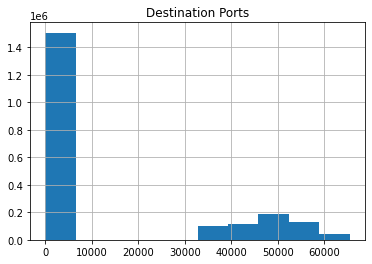

In [24]:
# View distribution of CIC destination ports
cic_categorical['Dst Port'].astype(dtype=int).hist()
plt.title('Destination Ports')

Text(0.5, 1.0, 'Destination Ports')

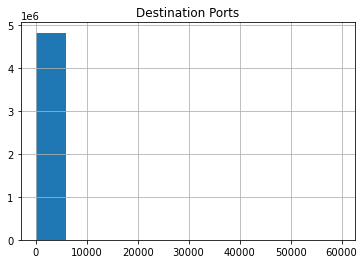

In [25]:
# View distribution of USB destination ports
usb_categorical['Dst Port'].astype(dtype=int).hist()
plt.title('Destination Ports')

Text(0.5, 1.0, 'Top 10 Destination Ports')

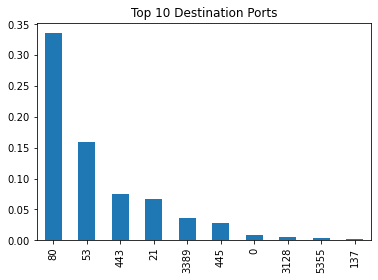

In [26]:
# View percentage distribution of top 10 CIC destination ports
top_10 = cic_categorical['Dst Port'].value_counts()[:10] / cic_categorical['Dst Port'].shape[0]
top_10.plot(kind='bar')
plt.title('Top 10 Destination Ports')

Text(0.5, 1.0, 'Top 10 Destination Ports')

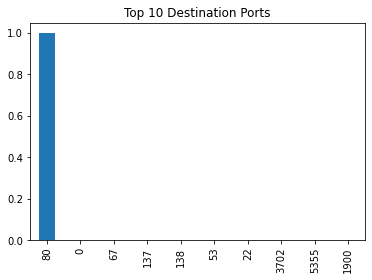

In [27]:
# View percentage distribution of top 10 USB destination ports
top_10 = usb_categorical['Dst Port'].value_counts()[:10] / usb_categorical['Dst Port'].shape[0]
top_10.plot(kind='bar')
plt.title('Top 10 Destination Ports')